In [ ]:
%reset -f

In [ ]:
%pwd

In [ ]:
%%javascript
document.addEventListener('keydown', function(e) {
  if (e.key === 'F12') {
    e.preventDefault()
    if (document.fullscreenElement) {
      document.exitFullscreen();
    } else {
      document.documentElement.requestFullscreen();
    }
  }
});


In [6]:
%reset -f
import pandas as pd
import arcpy
import os
from IPython.display import display

myProject = 'MyProject1'
projDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects\{}'.format(myProject)
dataDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects\{}\Data'.format(myProject)
gdbDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects\{}\{}.gdb'.format(myProject, myProject)

arcpy.env.overwriteOutput = True

if os.path.exists(os.path.join(projDIR, 'schema.ini')):
  os.remove(os.path.join(projDIR, 'schema.ini'))

for f in os.listdir(projDIR):
  if 'RasterToNetCD' in f:
    os.remove(os.path.join(projDIR, f))

arcpy.management.Delete(os.path.join(gdbDIR, 'clip_raster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'NoData_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'Filled_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'FloatIsoCluster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'RasterToPoint'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l3'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l4'))

data_files = os.listdir(dataDIR)

input_string = ';'.join(data_files)
input_list = input_string.split(';')
band_n = len(input_list)

print('ArcPy imported')

ArcPy imported


In [ ]:
#FEATURES AND RASTERS FOR CLIPPING, ZONAL STATS
#Creates shapefile of 4 states footprint
#Clips us_eco_l4.shp and us_eco_l3.shp
#Creates rasters of l3 and l4 polygons
#Creates latitude map

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CCSM4_1974_2013_ero.tif'],
    input_names=['raster'],
    expression='raster >= 0'
  )
output_raster.save(os.path.join(gdbDIR, 'clip_raster'))

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(outputZFlag='Disabled', outputMFlag='Disabled'):
  arcpy.conversion.RasterToPolygon(
    in_raster='clip_raster',
    out_polygon_features=os.path.join(gdbDIR, 'clip_shape'),
    simplify='SIMPLIFY',
    raster_field='Value',
    create_multipart_features='SINGLE_OUTER_PART',
    max_vertices_per_feature=None
  )

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l4', 'us_eco_l4_no_st.shp'),
  out_dataset='us_eco_l4',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l3', 'us_eco_l3.shp'),
  out_dataset='us_eco_l3',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.analysis.Clip(
  in_features='us_eco_l4',
  clip_features='clip_shape',
  out_feature_class='us_eco_l4_clip',
  cluster_tolerance=None
)

arcpy.analysis.Clip(
  in_features='us_eco_l3',
  clip_features='clip_shape',
  out_feature_class='us_eco_l3_clip',
  cluster_tolerance=None
)

arcpy.conversion.PolygonToRaster(
    in_features='us_eco_l4_clip',
    value_field='US_L4CODE',
    out_rasterdataset='us_eco_l4_raster',
    cell_assignment='CELL_CENTER',
    priority_field='NONE',
    cellsize='clip_raster',
    build_rat='BUILD'
)

arcpy.conversion.PolygonToRaster(
    in_features='us_eco_l3_clip',
    value_field='US_L3CODE',
    out_rasterdataset='us_eco_l3_raster',
    cell_assignment='CELL_CENTER',
    priority_field='NONE',
    cellsize='clip_raster',
    build_rat='BUILD'
)

arcpy.conversion.RasterToPoint(
  in_raster='us_eco_l3_raster',
  out_point_features='RasterToPoint',
  raster_field='Value'
)

arcpy.management.AddXY(
  in_features='RasterToPoint'
)

arcpy.conversion.PointToRaster(
  in_features='RasterToPoint',
  value_field='POINT_Y',
  out_rasterdataset='Latitude',
  cell_assignment='MOST_FREQUENT',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='DO_NOT_BUILD'
)



In [8]:
#Runs principle component tools to get
#the informational output files.

#input_string = uncorr_input_string

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster=os.path.join(gdbDIR, 'CompositeBands')
  )

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save(os.path.join(gdbDIR, 'NoData_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Extract_Composite'))

with arcpy.EnvManager(scratchWorkspace=projDIR):
  out_multiband_raster = arcpy.sa.PrincipalComponents(
    in_raster_bands='Extract_Composite',
    number_components=band_n,
    out_data_file='pca_info.txt'
  )
out_multiband_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['Princip_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

print('DONE')


DONE


In [14]:
#Prints correlation matrix

pca_info_path = 'pca_info.txt'
input_list = uncorr_input_list

with open(os.path.join(projDIR, pca_info_path)) as f:
  lines = f.readlines()

for i, line in enumerate(lines):
  if 'CORRELATION MATRIX' in line:
    hdr_line_idx = i
    for j, l in enumerate(lines[hdr_line_idx:]):
      if '#  ========' in l:
        ftr_line_idx = hdr_line_idx + j
        break
    break

start_idx = hdr_line_idx + 4
end_idx = ftr_line_idx - 1

corr_m_lines = lines[start_idx:end_idx + 1]

corr_data = []
for l in corr_m_lines:
  row = l.split()
  corr_data.append([float(x) for x in row[1:]])

corr_df = pd.DataFrame(corr_data)

def vif_fn(x):
  if x != 1:
    vif = (1)/(1 - x**2)
  else:
    vif = 0
  return vif

vif_df = corr_df.map(vif_fn)

high_value_mask = vif_df >= 5
stacked_mask = high_value_mask.stack()
result = stacked_mask[stacked_mask]

matrix_index_col_list = []
for (index, col), _ in result.items():
  matrix_index_col_list.append([index, col])

index_col_list = []
for l in matrix_index_col_list:
  if l not in index_col_list and l.reverse() not in index_col_list:
    index_col_list.append(l)

print('VIF FACTORS >=5:')  
for index, col in index_col_list:
  print(f"Index: {index}, Column: {col}, Value: {vif_df.loc[index, col]}")
  print(input_list[index], input_list[col])



VIF FACTORS >=5:
Index: 23, Column: 5, Value: 13.972061953939079
tmomx_1974_2013.tif DEM_Elev.tif


In [ ]:
#Removal of multicolinearity from inputs with VIF > 5

removal_choices = ['pmomx_1974_2013.tif', 'CCSM4_1974_2013_pet.tif', 'DEM_Elev.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'tmean_1974_2013.tif']
print(removal_choices)
print(len(removal_choices))

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)
band_n = len(uncorr_input_list)
print(uncorr_input_list)
print(band_n)


In [13]:
#Removal of multicolinearity from inputs with VIF > 5 EXCEPT FOR DEM_Elev.tif

removal_choices = ['pmomx_1974_2013.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'tmean_1974_2013.tif']
print(removal_choices)
print(len(removal_choices))

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)
band_n = len(uncorr_input_list)
print(uncorr_input_list)
print(band_n)


['pmomx_1974_2013.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'tmean_1974_2013.tif']
8
['accm_1974_2013.tif', 'CCSM4_1974_2013_consec.tif', 'CCSM4_1974_2013_ero.tif', 'CCSM4_1974_2013_ndays.tif', 'CCSM4_1974_2013_swe.tif', 'DEM_Elev.tif', 'DEM_Slope.tif', 'pmomn_1974_2013.tif', 'POL_bd.tif', 'POL_clay.tif', 'POL_ksat.tif', 'POL_om.tif', 'POL_ph.tif', 'POL_sand.tif', 'POL_silt.tif', 'RAP_afgNPP.tif', 'RAP_bgr.tif', 'RAP_ltr.tif', 'RAP_pfgNPP.tif', 'RAP_shr.tif', 'RAP_shrNPP.tif', 'RAP_treNPP.tif', 'tmomn_1974_2013.tif', 'tmomx_1974_2013.tif']
24


In [ ]:
#Iso Cluster using PCA as input and multidimensional raster.

input_string = uncorr_input_string

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster=os.path.join(gdbDIR, 'CompositeBands')
  )

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save(os.path.join(gdbDIR, 'NoData_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Extract_Composite'))

import random
threedigits = [str(x) for x in random.sample(range(0, 10), 3)]

arcpy.md.RasterToNetCDF(
  in_raster='Extract_Composite',
  out_netCDF_file=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  variable='Extract_Composite',
  variable_units='',
  x_dimension='lon',
  y_dimension='lat',
  band_dimension='band',
  fields_to_dimensions=None,
  compression_level=0
)

arcpy.md.MakeMultidimensionalRasterLayer(
  in_multidimensional_raster=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  out_multidimensional_raster_layer='MultidimRasterLyr',
  variables='Extract_Composite',
  dimension_def='ALL',
  dimension_ranges=None,
  dimension_values=None,
  dimension='',
  start_of_first_iteration='',
  end_of_first_iteration='',
  iteration_step=None,
  iteration_unit='',
  template='-120.00833328533 31.3333333207995 -102.991666625469 42.00833331653 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  dimensionless='DIMENSIONS',
  spatial_reference=None
)

arcpy.ia.MultidimensionalPrincipalComponents(
  in_multidimensional_raster='MultidimRasterLyr',
  mode='DIMENSION_REDUCTION',
  dimension='band',
  out_pc=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
  out_loadings=os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'),
  out_eigenvalues=os.path.join(gdbDIR, 'eigenvalues'),
  variable='Extract_Composite',
  number_of_pc='99%'
)

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  Output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
    Number_of_classes=15,
    Minimum_class_size=20,
    Sample_interval=10,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
Output_classified_raster.save(os.path.join(gdbDIR, 'IsoCluster'))

print('DONE')


In [ ]:
#Iso Cluster using composite as input.

#input_string = uncorr_input_string

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster=os.path.join(gdbDIR, 'CompositeBands')
  )

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save('NoData_Composite')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save('Filled_Composite')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save('Extract_Composite')

with arcpy.EnvManager(scratchWorkspace=os.path.join(gdbDIR)):
  Output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands='Extract_Composite',
    Number_of_classes=15,
    Minimum_class_size=20,
    Sample_interval=10,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
Output_classified_raster.save('FloatIsoCluster')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.ia.Int(
    in_raster_or_constant='FloatIsoCluster'
  )
out_raster.save('IsoCluster')

print('DONE')


In [17]:
arcpy.env.workspace = gdbDIR

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l3_clip',
  zone_field='US_L3CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco3',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Elev.tif'),
  out_table='Zonal_elev',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_elev',
  out_table=os.path.join(projDIR, 'Zonal_elev.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Slope.tif'),
  out_table='Zonal_slpe',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_slpe',
  out_table=os.path.join(projDIR, 'Zonal_slpe.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'accm_1974_2013.tif'),
  out_table='Zonal_accm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_accm',
  out_table=os.path.join(projDIR, 'Zonal_accm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'tmean_1974_2013.tif'),
  out_table='Zonal_tavg',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_tavg',
  out_table=os.path.join(projDIR, 'Zonal_tavg.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'RAP_bgr.tif'),
  out_table='Zonal_bare',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bare',
  out_table=os.path.join(projDIR, 'Zonal_bare.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_om.tif'),
  out_table='Zonal_orgm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_orgm',
  out_table=os.path.join(projDIR, 'Zonal_orgm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_clay.tif'),
  out_table='Zonal_clay',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_clay',
  out_table=os.path.join(projDIR, 'Zonal_clay.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_bd.tif'),
  out_table='Zonal_bulk',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bulk',
  out_table=os.path.join(projDIR, 'Zonal_bulk.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_ph.tif'),
  out_table='Zonal_pphh',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_pphh',
  out_table=os.path.join(projDIR, 'Zonal_pphh.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster='Latitude',
  out_table='Zonal_ylat',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_ylat',
  out_table=os.path.join(projDIR, 'Zonal_ylat.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)


<Result 'C:\\Users\\fullh\\Documents\\ArcGIS\\Projects\\MyProject1\\Zonal_ylat.csv'>

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

files = [f for f in os.listdir(projDIR) if 'Zonal' in f and f[-4:] == '.csv']
labels = [f.split('_')[1][:-4] for f in files]

df = pd.DataFrame()
for i, f in enumerate(files):
  idf = pd.read_csv(os.path.join(projDIR, f))
  df[labels[i]] = idf['MEAN']

df['orgm'] = df['orgm'].apply(lambda x: 10**x)

temp_order_df = df.sort_values(by='tavg', ascending=False)
temp_order_df.index.name = 'arc_id'
df = temp_order_df.reset_index()

#https://colorswall.com/palette/176957
colors = ['#ff355e', '#fd5b78', '#ff6037', '#ff9966', '#ff9933', '#ffcc33', '#ffff66', '#ccff00', '#66ff66', '#aaf0d1', '#16d0cb', '#50bfe6', '#9c27b0', '#ee34d2', '#ff00cc']

def plot_fn():
  z = np.polyfit(x, y, deg=1)
  p = np.poly1d(z)
  ax.margins(0.25, 0.25)
  ax.plot(x, p(x), color='black', linestyle=':', linewidth=1, zorder=-999)
  ax.scatter(x, y, s=50, c=colors, edgecolor='k')
  ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
  xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[1]
  for i in range(1, len(x)+1):
    ax.text(x[i-1] - 0.025*(xmax - xmin), y[i-1] + 0.025*(ymax - ymin), i, fontsize=9)

print('DONE')

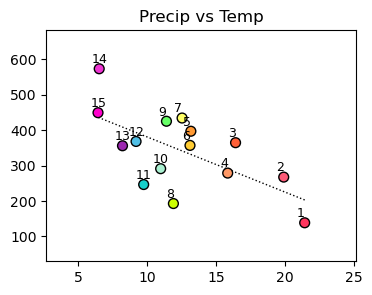

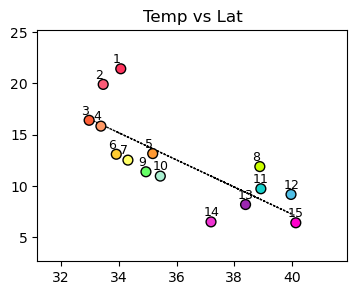

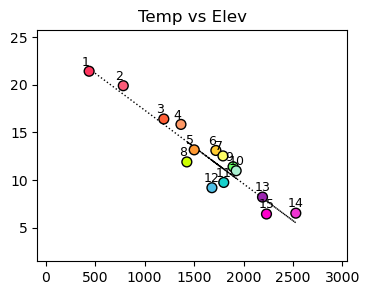

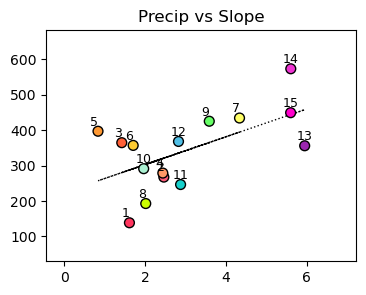

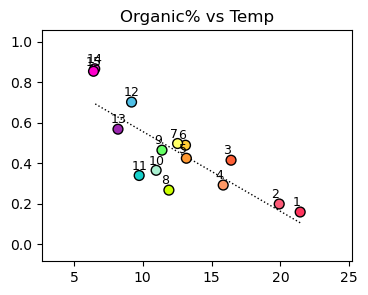

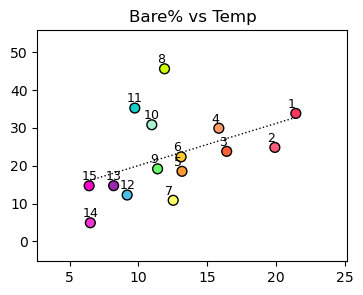

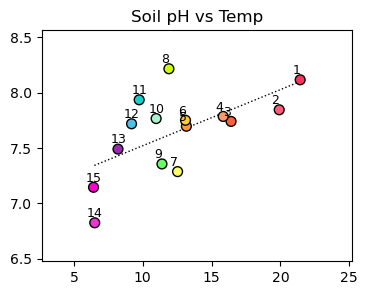

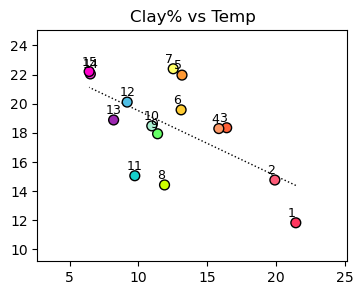

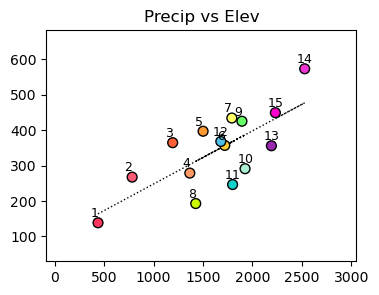

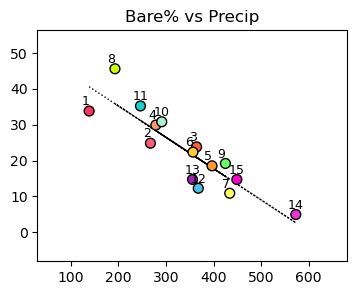

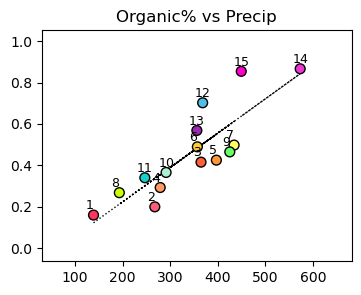

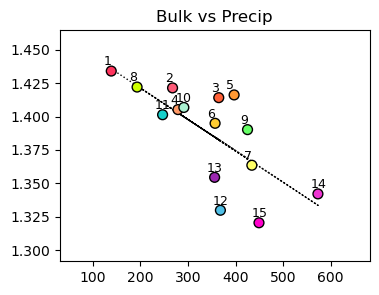

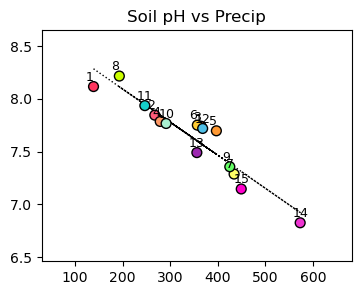

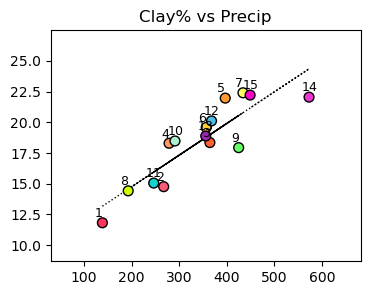

In [19]:

#########################################################################################

x = df['tavg']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Temp')
plot_fn()

#########################################################################################

x = df['ylat']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Lat')
plot_fn()

#########################################################################################

x = df['elev']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Elev')
plot_fn()

#########################################################################################

x = df['slpe']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Slope')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Temp')
plot_fn()

#########################################################################################

x = df['elev']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Elev')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bulk']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bulk vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Precip')
plot_fn()
